# Generation of tables and figures

In [1]:
import pickle

v_acc_d = {}

f = open('results/RfamNovel_constant.pckl', 'rb')
v_acc_d.update({'Constant' : pickle.load(f)})
f.close()

f = open('results/RfamNovel_random.pckl', 'rb')
v_acc_d.update({'Random' : pickle.load(f)})
f.close()

f = open('results/RfamNovel_new.pckl', 'rb')
v_acc_d.update({'New' : pickle.load(f)})
f.close()

import numpy as np
from tensorflow import keras
from sklearn import preprocessing


train_labels=np.load("train_labels.npy")
val_labels=np.load("val_labels.npy")
test_labels=np.load("test_labels.npy")

num_classes = len(np.unique(train_labels))

le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_num = le.transform(train_labels)
val_labels_num = le.transform(val_labels)
test_labels_num = le.transform(test_labels)

train_labels_bin = keras.utils.to_categorical(train_labels_num, num_classes)
val_labels_bin = keras.utils.to_categorical(val_labels_num, num_classes)
test_labels_bin = keras.utils.to_categorical(test_labels_num, num_classes)





### Plots the accuracy/MCC vs boundary noise

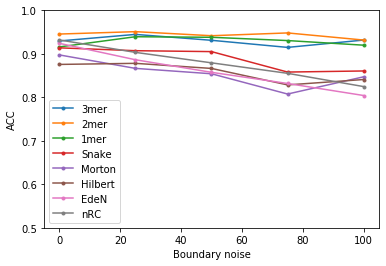

In [4]:
# plots accuracy or MCC VS bnoise
from sklearn.metrics import *
from ExpConfiguration import *


import matplotlib.pyplot as plt
y_true = np.argmax(test_labels_bin, axis=1)

# CHANGE HERE plot parameters
nl=3  # cnn layer to plot
#padd = 'Constant'
#padd = 'Random'
padd = 'New' 
#pmetric = 'MCC'
#pmetricf = matthews_corrcoef
pmetric = 'ACC'
pmetricf = accuracy_score

v_acc = v_acc_d[padd]
fig, ax = plt.subplots()
plt.xlabel('Boundary noise')
plt.ylabel(pmetric)
#plt.title('CNN n. layers = '+str(nl))
plt.ylim(0.5, 1) 
for en in seqEncoders:
    mtr=[]
    for bn in bnoise:
        y_pred = v_acc[str(nl)][en['filename']][str(bn)]
        mtr.append(pmetricf(y_true,y_pred))
        #print(en['filename'],bn,matthews_corrcoef(y_true,y_pred),accuracy_score(y_true,y_pred))
            
    ax.plot(bnoise, mtr, label=en['filename'],marker='o',markersize=3)

# add Eden results
mtr=[]
for bn in bnoise:
    y_pred = np.loadtxt('eden/test_pred_eden_'+str(bn)+'.txt',dtype='str')
    y_true = np.loadtxt('eden/test_labels_eden_'+str(bn)+'.txt',dtype='str')
    mtr.append(pmetricf(y_true,y_pred))
    #mtr.append(accuracy_score(y_true,y_pred))
    #print('EdeN',bn,matthews_corrcoef(y_true,y_pred),accuracy_score(y_true,y_pred))

ax.plot(bnoise, mtr, label='EdeN',marker='o',markersize=3)
# add nRC results
mtr=[]
for bn in bnoise:
    y_pred = np.loadtxt('nrc/test_pred_nrc_'+str(bn)+'.txt',dtype='str')
    y_true = np.loadtxt('nrc/test_labels_nrc_'+str(bn)+'.txt',dtype='str')
    mtr.append(pmetricf(y_true,y_pred))
    #print('nRC',bn,matthews_corrcoef(y_true,y_pred),accuracy_score(y_true,y_pred))


ax.plot(bnoise, mtr, label='nRC',marker='o',markersize=3)
ax.legend()
plt.savefig('figs/plot_bnoise-m'+pmetric+'_nl'+str(nl)+'_p'+padd+'.pdf')




### Plots accuracy with different padding schemas

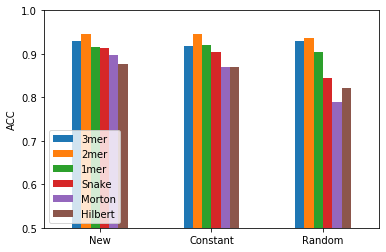

In [3]:
from sklearn.metrics import *
from ExpConfiguration import *
import matplotlib.pyplot as plt
import pandas as pd

# CHANGE HERE plot parameters
nl=3  # cnn layer to plot
bn = 0 # boundary noise
#pmetric = 'MCC'
#pmetricf = matthews_corrcoef
pmetric = 'ACC'
pmetricf = accuracy_score


y_true = np.argmax(test_labels_bin, axis=1)
index = ['New', 'Constant', 'Random']
cols = {}
for en in seqEncoders:
    y_pred = v_acc_d['New'][str(nl)][en['filename']][str(bn)]
    pnew = pmetricf(y_true,y_pred)
    y_pred = v_acc_d['Constant'][str(nl)][en['filename']][str(bn)]
    pcns = pmetricf(y_true,y_pred)
    y_pred = v_acc_d['Random'][str(nl)][en['filename']][str(bn)]
    prnd = pmetricf(y_true,y_pred)

    performance = [pnew,pcns,prnd]
    cols.update({en['filename'] : performance})



df = pd.DataFrame(cols, index=index)
ax = df.plot.bar(rot=0,ylim=(0.5,1))

ax.legend(loc='lower left')
#plt.title('Input padding symbol')
plt.ylabel('ACC')
plt.savefig('figs/plot-padding.pdf')




### Plots accuracy/MCC with different CNN n. of layers

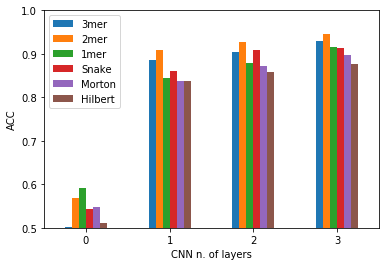

In [5]:
from sklearn.metrics import *
from ExpConfiguration import *
import matplotlib.pyplot as plt
import pandas as pd

# CHANGE HERE plot parameters
bn = 0 # boundary noise
padd = 'New'  # padding to plot
#pmetric = 'MCC'
#pmetricf = matthews_corrcoef
pmetric = 'ACC'
pmetricf = accuracy_score


y_true = np.argmax(test_labels_bin, axis=1)
index = ['0', '1', '2','3']
cols = {}
for en in seqEncoders:
    y_pred = v_acc[str(0)][en['filename']][str(bn)]
    p0 = pmetricf(y_true,y_pred)
    y_pred = v_acc[str(1)][en['filename']][str(bn)]
    p1 = pmetricf(y_true,y_pred)
    y_pred = v_acc[str(2)][en['filename']][str(bn)]
    p2 = pmetricf(y_true,y_pred)
    y_pred = v_acc[str(3)][en['filename']][str(bn)]
    p3 = pmetricf(y_true,y_pred)
    
    performance = [p0,p1,p2,p3]
    cols.update({en['filename'] : performance})



df = pd.DataFrame(cols, index=index)
ax = df.plot.bar(rot=0,ylim=(0.5,1))

ax.legend(loc='upper left')
#plt.title('CNN number of layers')
plt.ylabel('ACC')
plt.xlabel('CNN n. of layers')
plt.savefig('figs/plot-cnnlayers.pdf')



## Generates tables with precisions, recalls, and F1-measures

In [6]:
# tables precision recall f1 and macro/weighted averages 
# at certain bnoise and n CNN layers 

from sklearn.metrics import *
import pandas as pd
import numpy as np
from ExpConfiguration import *

# CHANGE HERE plot parameters
nl=3  # cnn layer 
bn = 0 # boundary noise
padd = 'New'  # padding to plot


v_acc = v_acc_d[padd]
y_true = np.argmax(test_labels_bin, axis=1)
y_true = le.inverse_transform(y_true)

dfs = {}
for en in seqEncoders:
    y_pred = v_acc[str(nl)][en['filename']][str(bn)]
    y_pred = le.inverse_transform(y_pred)
    cr = classification_report(y_true,y_pred,output_dict=True,digits=2)
    df1 = pd.DataFrame(cr).drop(index=['support'])
    df1.drop(columns=['accuracy'])
    df1.index = ['P','R','F1']
    dfs[en['filename']] = df1

y_pred = np.loadtxt('eden/test_pred_eden_'+str(bn)+'.txt',dtype='str')
y_true = np.loadtxt('eden/test_labels_eden_'+str(bn)+'.txt',dtype='str')
cr = classification_report(y_true,y_pred,output_dict=True,digits=2)
df1 = pd.DataFrame(cr).drop(index=['support'])
df1.drop(columns=['accuracy'])
df1.index = ['P','R','F1']
dfs['EdeN'] = df1

y_pred = np.loadtxt('nrc/test_pred_nrc_'+str(bn)+'.txt',dtype='str')
y_true = np.loadtxt('nrc/test_labels_nrc_'+str(bn)+'.txt',dtype='str')
cr = classification_report(y_true,y_pred,output_dict=True,digits=2)
df1 = pd.DataFrame(cr) #.drop(index=['support'])
df1.drop(columns=['accuracy'])
df1.index = ['P','R','F1','Class size']
dfs['nRC'] = df1

df = pd.concat(dfs)
df = df.transpose()
df.astype({('nRC','Class size'): 'int32'})

with open('tables/prf-table_bn'+str(bn)+'_nl'+str(nl)+'_p'+padd+'.tex','w') as tf:
    tf.write(df.to_latex(float_format="{:0.2f}".format))

df


3mer                          2mer                      \
                     P         R        F1         P         R        F1   
RF00001       0.995141  0.896037  0.942993  0.984865  0.937725  0.960717   
RF00005       0.957721  0.932005  0.944688  0.958916  0.980511  0.969593   
RF00015       0.979798  0.877828  0.926014  0.990000  0.895928  0.940618   
RF00016       0.933333  0.940299  0.936803  0.891892  0.985075  0.936170   
RF00019       0.976242  0.991228  0.983678  0.976190  0.989035  0.982571   
RF00020       0.351648  0.390244  0.369942  0.342466  0.304878  0.322581   
RF00026       0.997677  0.947601  0.971994  0.998277  0.958632  0.978053   
RF00029       0.028169  0.400000  0.052632  0.120000  0.600000  0.200000   
RF00050       1.000000  0.989418  0.994681  0.984334  0.997354  0.990802   
RF00059       0.970757  0.978219  0.974474  0.982714  0.983344  0.983029   
RF00066       0.509728  0.984962  0.671795  0.839744  0.984962  0.906574   
RF00097       0.970255  0.955370  0.962755  0.984419  0.969317  0.976810   
RF00156       0.797468  0.797468  0.797468  0.929825  0.670886  0.779412   
RF00162       0.926471  0.984375  0.954545  0.851351  0.984375  0.913043   
RF00169       0.707635  0.997375  0.827887  0.961957  0.929134  0.945260   
RF00409       1.000000  1.000000  1.000000  0.976190  0.995951  0.985972   
RF00504       0.951318  0.981172  0.966014  0.862568  0.997908  0.925315   
RF00557       0.946667  0.959459  0.953020  0.935065  0.972973  0.953642   
RF00560       0.944954  0.936364  0.940639  0.569948  1.000000  0.726073   
RF00619       0.358025  0.617021  0.453125  0.500000  0.553191  0.525253   
RF00645       0.550000  0.709677  0.619718  0.666667  0.967742  0.789474   
RF00875       0.733728  0.992000  0.843537  0.568807  0.992000  0.723032   
RF00876       0.424242  1.000000  0.595745  0.613636  0.964286  0.750000   
RF00906       0.870130  0.893333  0.881579  0.873239  0.826667  0.849315   
RF01055       0.552764  0.990991  0.709677  0.762238  0.981982  0.858268   
RF01059       1.000000  0.555556  0.714286  0.642857  1.000000  0.782609   
RF01705       0.982578  0.699752  0.817391  0.951807  0.588089  0.726994   
RF01725       0.890411  0.984848  0.935252  0.802469  0.984848  0.884354   
RF01739       0.370370  1.000000  0.540541  0.526316  1.000000  0.689655   
RF01942       0.933029  0.985531  0.958561  0.984874  0.942122  0.963024   
accuracy      0.929607  0.929607  0.929607  0.945528  0.945528  0.945528   
macro avg     0.787009  0.878938  0.808048  0.801121  0.897964  0.830607   
weighted avg  0.949825  0.929607  0.935555  0.954597  0.945528  0.946760   

                  1mer                         Snake  ...   Hilbert            \
                     P         R        F1         P  ...         P         R   
RF00001       0.998822  0.872877  0.931612  0.998839  ...  0.980605  0.858724   
RF00005       0.938577  0.919879  0.929134  0.933020  ...  0.932529  0.903854   
RF00015       0.984456  0.859729  0.917874  0.983784  ...  1.000000  0.687783   
RF00016       0.856209  0.977612  0.912892  0.903226  ...  0.654321  0.395522   
RF00019       0.945378  0.986842  0.965665  0.961290  ...  0.974249  0.995614   
RF00020       0.362069  0.256098  0.300000  0.357143  ...  0.172414  0.243902   
RF00026       0.953191  0.988417  0.970485  0.973239  ...  0.986620  0.935466   
RF00029       0.029851  0.400000  0.055556  0.000000  ...  0.040000  0.200000   
RF00050       0.956853  0.997354  0.976684  0.959288  ...  0.960630  0.968254   
RF00059       0.985133  0.976297  0.980695  0.923214  ...  0.902861  0.970532   
RF00066       0.768786  1.000000  0.869281  0.608295  ...  0.698324  0.939850   
RF00097       0.979971  0.955370  0.967514  0.832160  ...  0.996956  0.913529   
RF00156       0.868852  0.670886  0.757143  0.898734  ...  0.397959  0.493671   
RF00162       1.000000  0.945312  0.971888  0.975000  ...  0.977528  0.679688   
RF00169       0.923077  0.944882  0.933852  0.902256  ...  0.